# Memory Benchmark

# Benchmark

In this notebook, we assess how memory and time efficiency are affected by using different functions of `Keras` (specifically with the `TF` backend).
We also do not really do anything interesting data-wise, we just use random data to closely enough simulate openAI's `Gym` CartPole-v1 environment.

First we define some utility functions.

In [1]:
import psutil
from time import perf_counter
from dql.utils.namespaces import P

p = psutil.Process()
reps, eps = 10, 100

def ping():
    return p.memory_info().rss, perf_counter()

def calc(prev):
    mem, time = ping()
    return mem - prev[0], time - prev[1]

def fmtMem(mem):
    if mem < 1024:
        return f'{int(mem)} B'
    elif mem < 1024**2:
        return f'{mem / 1024:.2f} KB'
    elif mem < 1024**3:
        return f'{mem / 1024**2:.2f} MB'

def bench(mem, time):
    mem, time = calc((mem, time))
    print(f'Memory: {fmtMem(mem)}')
    if time > 0:
        print(f'Time: {time:.2f} s')

### Loading `NumPy`, `TensorFlow` and `Keras` libraries

In [2]:
m, t = ping()
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
bench(m, t)

Memory: 303.36 MB
Time: 3.46 s


### Initializing `np.zeros`

In [3]:
m, t = ping()
R = np.zeros((reps, eps), dtype=np.int16)
bench(m, t)

Memory: 0 B
Time: 0.00 s


As we can see, initializing `np.zeros` does not actually allocate any memory.

### Creating `Keras` model

In [4]:
m, t = ping()
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))
bench(m, t)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Memory: 25.20 MB
Time: 0.12 s


Compiling `Keras` model

In [5]:
m, t = ping()
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
bench(m, t)

Memory: 1.58 MB
Time: 0.01 s


Main loop: `model.fit`, `model.predict` and `model()` calls

In [6]:
mP, mCF, mCT, mF = [], [], [], []

for r in range(reps):
    for e in range(eps):
        print(f'\r{r*eps+e+1} / {eps*reps}    ', end='', flush=True)
        randomState = np.random.random((1, 4))
        randomReward = np.random.random()
        randomTarget = np.random.random((1, 2))
        randomAction = np.random.randint(0, 2)
        
        # array storage will be evaluated later
        R[r, e] = randomReward
        
        m, t = ping()
        _ = model.predict(randomState, verbose=0)
        mP.append(calc((m, t)))

        m, t = ping()
        _ = model(randomState, training=False).numpy()
        mCF.append(calc((m, t)))

        m, t = ping()
        _ = model(randomState, training=True).numpy()
        mCT.append(calc((m, t)))
        
        m, t = ping()
        model.fit(randomState, randomTarget, verbose=0)
        mF.append(calc((m, t)))

1 / 1000    

2023-04-04 18:09:35.568680: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1000 / 1000    

## Benchmark plots

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

smWin = 201
smPoly = 3

We define a function to remove the extreme outliers from the data.
Note that they will still be accounted for in the mean.

In [8]:
def removeOutliers(data):
    """ Remove outliers from data using median and standard deviation and set negative values to 0 """
    med = np.median(data)
    std = np.std(data)
    data[data > med + 2*std] = med
    data[data < med - 2*std] = med
    data[data < 0] = 0
    return data

### Memory usage

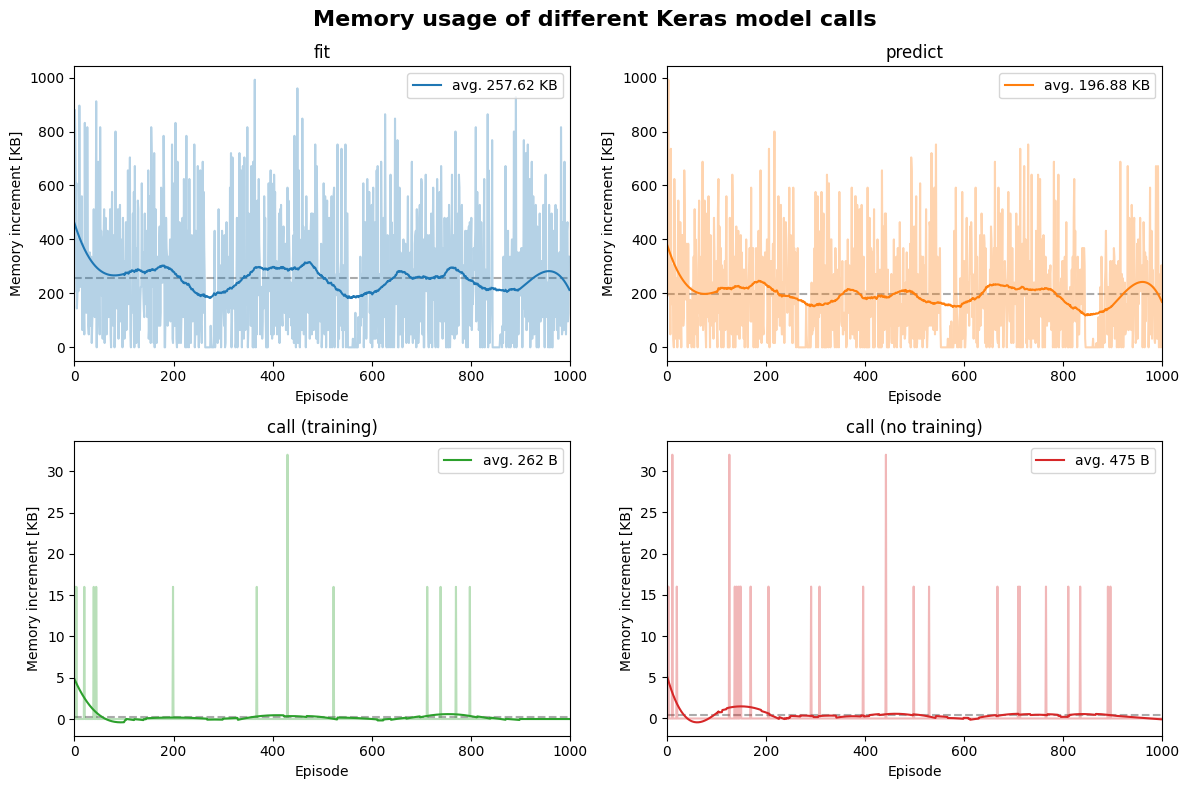

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
for i, ax, m, title in zip(range(4), (ax1, ax2, ax3, ax4), (mF, mP, mCT, mCF), ('fit', 'predict', 'call (training)', 'call (no training)')):
    data = np.array([m[0] for m in m]) / 1024
    nData = removeOutliers(data)
    ax.hlines(data.mean(), 0, len(data), color=f'k', linestyles='dashed', alpha=.33)
    ax.plot(data, alpha=.33, color=f'C{i}')
    ax.plot(savgol_filter(data, smWin, smPoly), color=f'C{i}', label=f'avg. {fmtMem(data.mean()*1024)}')
    ax.set_xlim(0, len(data))
    ax.set_xlabel('Episode')
    ax.set_ylabel('Memory increment [KB]')
    ax.legend(loc='upper right')
    ax.set_title(title)

fig.suptitle('Memory usage of different Keras model calls', fontsize=16, weight='bold')
fig.tight_layout()
fig.savefig(P.plots + '/memorybench.pdf', dpi=500);

### Time usage

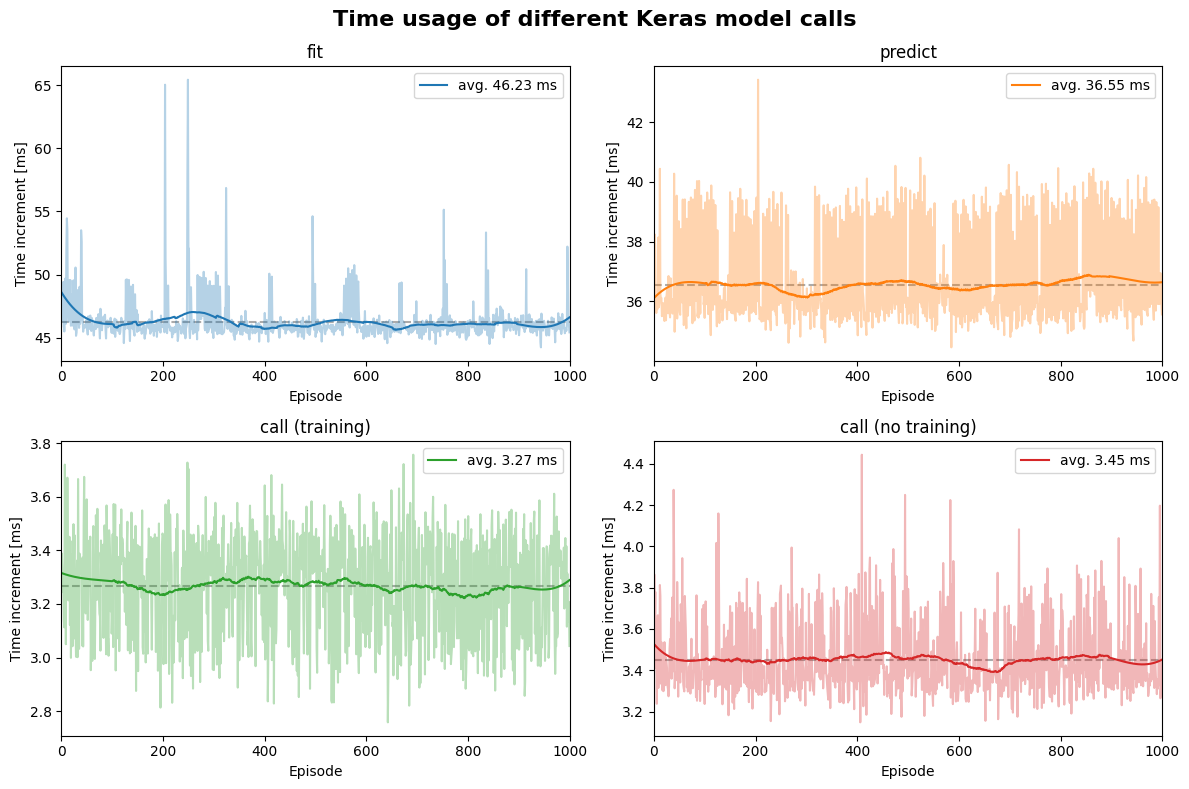

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

for i, ax, m, title in zip(range(4), (ax1, ax2, ax3, ax4), (mF, mP, mCT, mCF), ('fit', 'predict', 'call (training)', 'call (no training)')):
    data = np.array([m[1] for m in m]) * 1000
    pData = removeOutliers(data)
    ax.hlines(data.mean(), 0, len(data), color=f'k', linestyles='dashed', alpha=.33)
    ax.plot(pData, alpha=.33, color=f'C{i}')
    ax.plot(savgol_filter(pData, smWin, smPoly), color=f'C{i}', label=f'avg. {data.mean():.2f} ms')
    ax.set_xlim(0, len(data))
    ax.set_xlabel('Episode')
    ax.set_ylabel('Time increment [ms]')
    ax.legend(loc='upper right')
    ax.set_title(title)

fig.suptitle('Time usage of different Keras model calls', fontsize=16, weight='bold')
fig.tight_layout()
fig.savefig(P.plots + 'timebench.pdf', dpi=500);